<a href="https://colab.research.google.com/github/Aya-42/Bezier-Curve-GUI-/blob/main/denoising_autoencoder_v0_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proposed title:
**Deep denoising of 1D and 2D total scattering data**


---


Authors:
Hans, P* - Arabiat, A 1

1 SESAME


---


Journal: Science?

---


Abstract: Aim is to be efficient and have a good result.



---



---


Acknowledgements: University of Trento is thanked for generous financial support. PH thanks M Gailhanou for cooporation and discussion. PH thanks M Leoni for great support in writing a Horizon2020 Marie-Curie grant and of personal nature.

ToDos?

*   compare with Fourier-filtering end other methods (e.g. Noise2Self: Blind Denoising by Self-Supervision)
*   compare with SVD (singular value decomposition)
*   different loss function?
* find suited maximum intensities per pixel (different for 1D and 2D)
* maybe transfer learning

* prepare a function to plot results
* get 1D autoencoder working

* create named tuple for parameters so no accidental overwriting of constants can happen


In [ ]:
import os
#import shutil
#import datetime
import glob
import itertools

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numba import njit

#%matplotlib notebook
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.datasets import mnist

print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
### connect with google drive forcibly remount, call drive.mount("/content/drive", force_remount=True).

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pwd
! ls /content/drive
wd = '/content/drive/My Drive/data_on_the_fly/denoising_ae'

/content
MyDrive


# Define functions

In [ ]:
def func_get_common_start(filename, splitat='_', takethat=(0,-1)):
    """
    works for the case at hand22.7 kB
    -> find all wavelengths for all sizes
    """
    base = os.path.basename(filename)
    split = base.split(splitat)
    takethat = slice(*takethat)
    hook = '_'.join(split[takethat])
    return hook


def func_get_group_common_start(files, splitat='_', takethat=(0,-1)):
    """
    apparently only works with sorted input
    """
    groups = [list(g) for _, g in itertools.groupby(files, lambda x: func_get_common_start(x, splitat, takethat)) ]
    return groups


def func_bg(bg):
    """
    return a randomly chosen background of available ones
    """
    
    return bg


@njit
def func_combine_n_random_different_ranges(bg, input_array, number_of_combinations):
    """
    
    each function: one task -> scale  afterwards!
    
    take input list of lists of array
    take output array (defines number of elements that must be calculated)
    
    how must the input look like? :
    [number_positions][number_phases_available][number_variations_in_phase]
    
    this function might be accelerated by jit
    -> feed an empty n * m array (empty is faster. Contents will be overwritten anyhow)
    -> array[i] = bg*scale
    -> loop array[i] += phases*scale_
    1 para bg
    1 para phases -> pick n arrays -> pick one "size" randomly
    -> need loop that creates n-1 factors
    1 function to get mixing done
    
    take sampling for scaling for logatithmic distribition
    
    would like to omit repeated determination of lengths
    would like to omit picking same phase multiple times
    
    We can think about creating and directly returning the output array
    """
    out_list = []
    number_positions = len(input_array)
    
    #len_out_array = len(out_array)
    for counter in range(number_of_combinations):
        # pick one position
        position = np.random.choice(number_positions, 1, replace=False)[0]
        phases_array = input_array[position]
        
        # get random value < 1.
        scale = np.random.rand(1)[0]
        # "initialize" out_array as bg
        combined_array = bg * scale
        
        #define remaining possible scale as diff
        scale_diff = 1.0
        
        number_phases_available = len(phases_array)
        number_phases_picked = np.random.randint(number_phases_available)+1
        phases_picked = np.random.choice(number_phases_available, number_phases_picked, replace=False)
        for index_phases_picked in range(number_phases_picked):
            # usage of scale: the first scale comes from betore
            # the last scale is not used, but easier to calculate and drop
            #len_phases_picked = len(phases_picked)
            index_phase = phases_picked[index_phases_picked]
            number_available_patterns = len(phases_array[index_phase])
            scale_diff = scale_diff - scale
            # scale down to max < 1 and account for diff being the upper limit
            # rand gives size one array -> need to read it out
            scale = scale_diff*np.random.rand(1)[0]
            
            index_phase_to_add = np.random.randint(number_available_patterns)
            combined_array += phases_array[index_phase][index_phase_to_add] * scale
        out_list.append(combined_array)
    return out_list


def func_scale_patterns_randomly(input_list, MAX_INT_PER_PIXEL):
    """
    scale all input down do imax = 1 once before combining?
    or just here? I think it is better to do it before the combination
    """
    for i, array in enumerate(input_list):
        scale = np.random.beta(2, 6.4, 1)
        input_list[i] *= MAX_INT_PER_PIXEL * scale


def func_create_array_of_scaled_patterns(data_to_combine, funtion_generator, BATCH_SIZE, MAX_INT_PER_PIXEL):
    """
    """ 
    array_combined = funtion_generator(func_bg(bg), input_array=data_to_combine, number_of_combinations=BATCH_SIZE)
    func_scale_patterns_randomly(array_combined, MAX_INT_PER_PIXEL)
    
    array_combined = np.array(array_combined, dtype=np.float32)
    array_combined_noise = np.random.default_rng().poisson(array_combined)
    array_combined_noise = array_combined_noise.astype(np.float32)
    #np.array(array_combined_noise, dtype=np.float32)

    array_combined /= MAX_INT_PER_PIXEL
    array_combined_noise /= MAX_INT_PER_PIXEL

    return array_combined, array_combined_noise

In [ ]:
class class_batchGenerator_general(tf.keras.utils.Sequence):
    def __init__(self, data_to_combine, NUMBER_OF_BATCHES, BATCH_SIZE, function_generate_patterns=None):
        #self.x, self.y = x_set, y_set
        self.data_to_combine = data_to_combine
        self.number_of_batches = NUMBER_OF_BATCHES
        self.batch_size = BATCH_SIZE
        self.function_generate_patterns = function_generate_patterns


    def __len__(self):
        return self.number_of_batches


    def __getitem__(self, idx):
        return self.__data_generation(self.batch_size, self.data_to_combine)


    def __data_generation(self, BATCH_SIZE, data_to_combine):
        array_combined, array_combined_noise = func_create_array_of_scaled_patterns(data_to_combine, self.function_generate_patterns, BATCH_SIZE, MAX_INT_PER_PIXEL)
        return array_combined_noise.astype(np.float32), array_combined.astype(np.float32)#.flatten()


    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        We have no indexes
        '"""
        pass

# procedure for 2D
# load npys from dir
# group for combination procedure


In [ ]:
files = [f for f in glob.glob(f"{wd}/*18keV2Dpos*.npy")]
files = sorted(files)

def func_load_group_of_npys(group_of_groups):
    # load npys while grouping positions into phases
    def load_and_normalize(file):
        file = np.load(file)
        file /= max(file.flatten())
        return file

    return [[load_and_normalize(f) for f in group] for group in group_of_groups]

# in our case this sorts into tuples of the same phase
# transposing leads to groups of positions, e.g. pos1, pos2, pos3
grouped_loaded = np.array(func_get_group_common_start(files)).T
grouped_loaded = np.array([func_load_group_of_npys(func_get_group_common_start(group, takethat=(0,-2))) for group in grouped_loaded ])

grouped_loaded.shape

(3, 6, 8, 240, 560)

In [ ]:
  grouped_loaded = np.expand_dims(grouped_loaded, axis=-1)

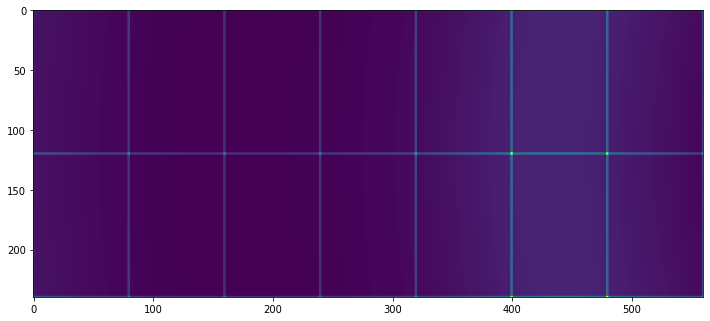

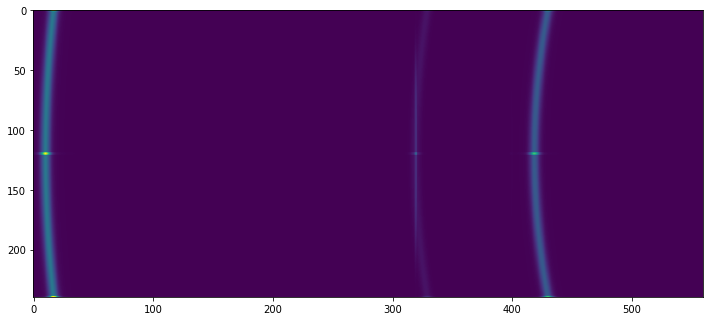

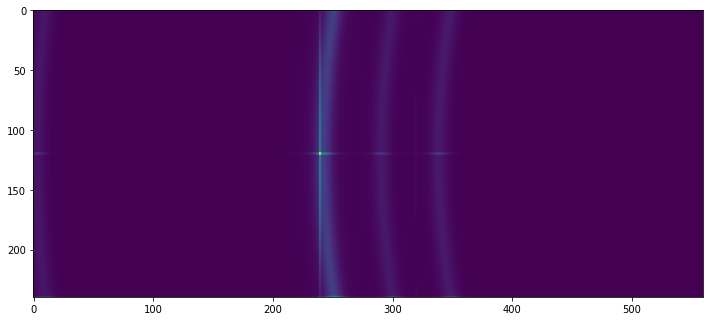

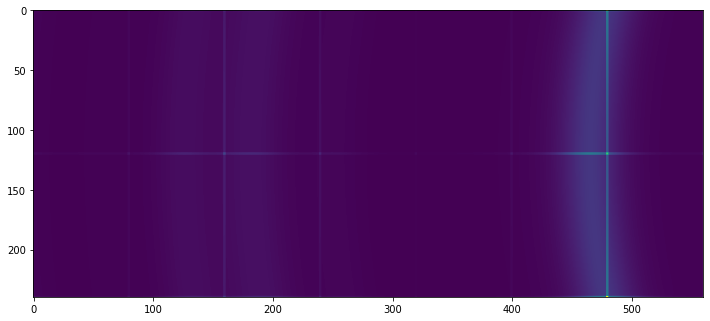

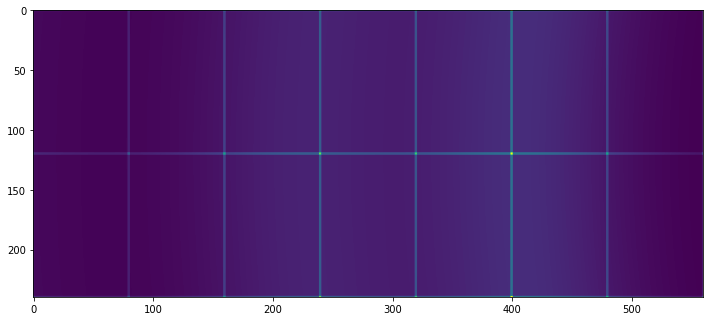

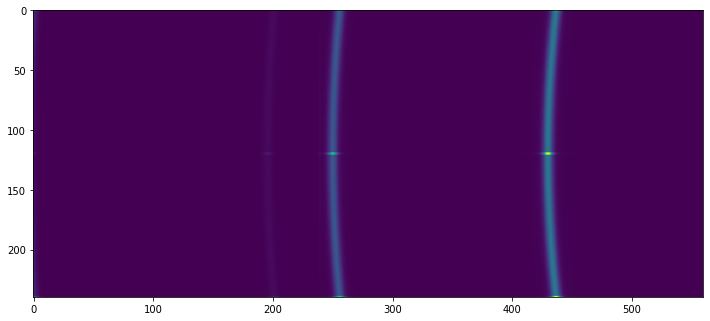

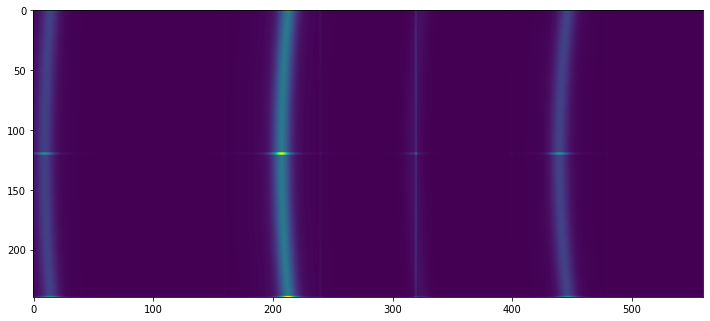

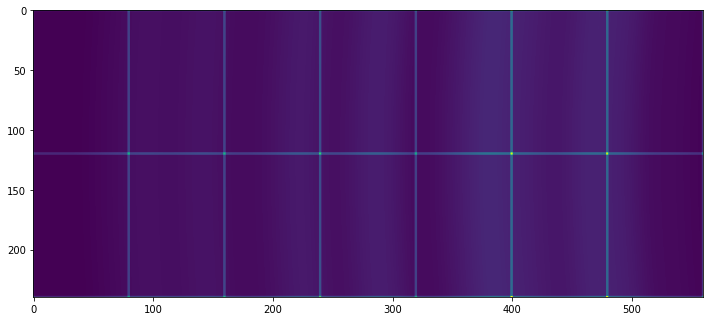

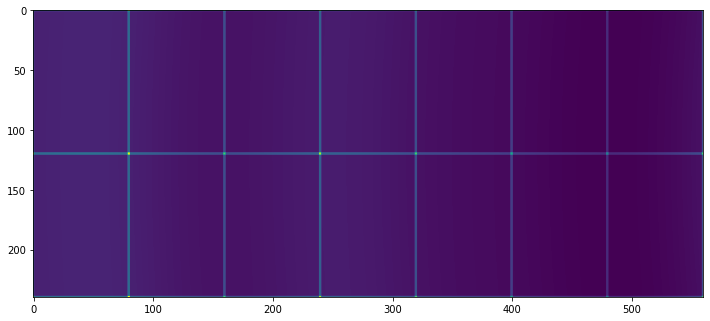

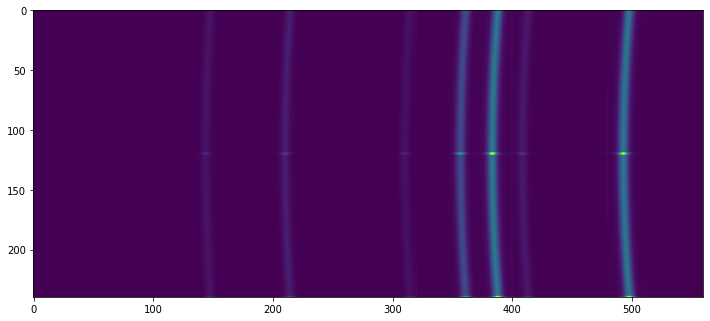

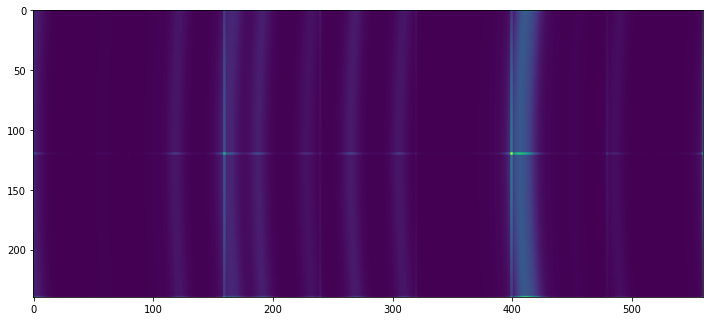

In [ ]:
total= len(files)//10
for work in grouped_loaded.reshape(-1, 240, 560)[::total]:
    # reshape to have list of images
    a = work
    #print(a)
    #a = np.flip(a, 1)
    
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(a)

In [ ]:
MAX_INT_PER_PIXEL = 300

phases_array = grouped_loaded


shape = phases_array.shape[3:]
# gives number of pixels
try:
    norm = math.prod(shape)
except:
    norm = shape[0]*shape[1]
#shapeber_phases_available = len(phases)
#len_pattern = len(phases[0][0])
bg = np.zeros(shape)
#array_combined = np.empty((5, *shape))

#max_scale_log = 9


array_combined, array_combined_noise = func_create_array_of_scaled_patterns(phases_array, func_combine_n_random_different_ranges, 5, MAX_INT_PER_PIXEL)
#array_combined /= MAX_INT_PER_PIXEL
#array_combined_noise /= MAX_INT_PER_PIXEL
#array_combined /= norm*1000

(5, 240, 560, 1) (5, 240, 560, 1)
pure - noisy - only noise


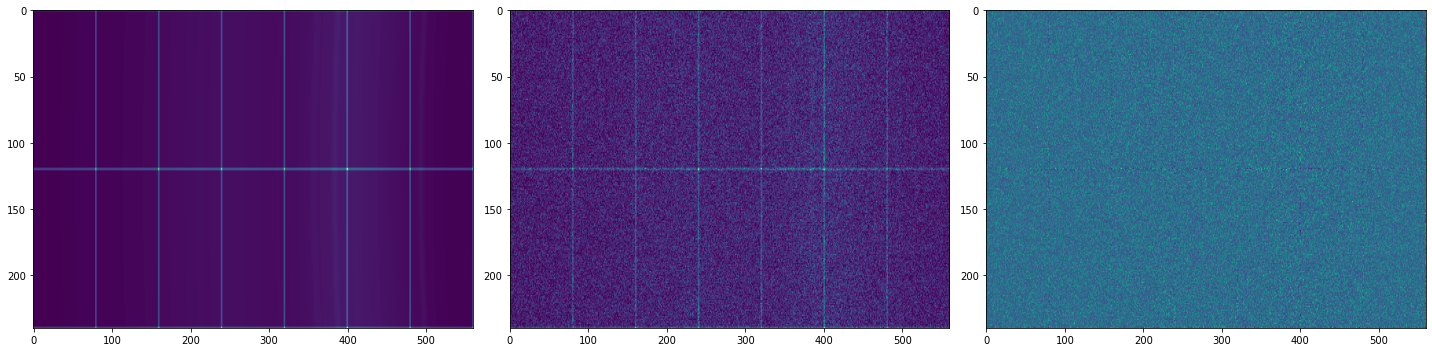

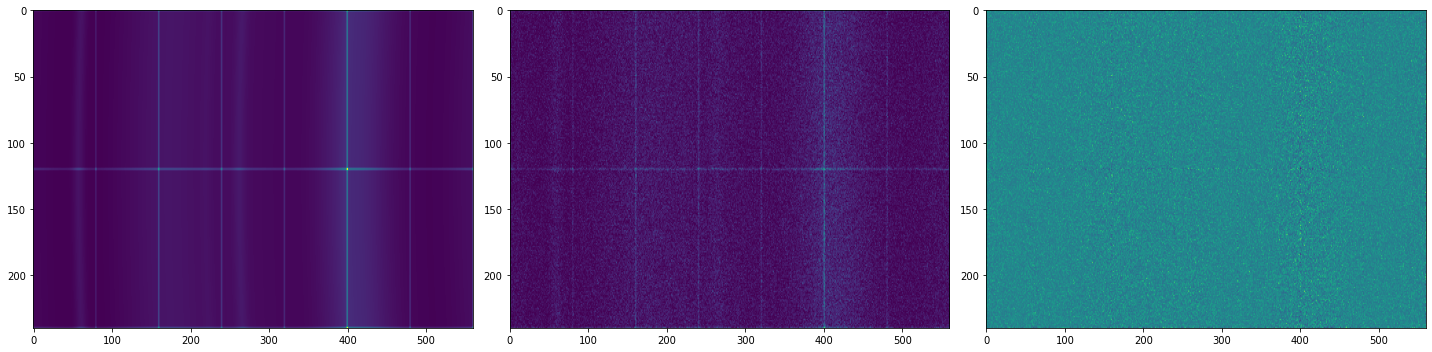

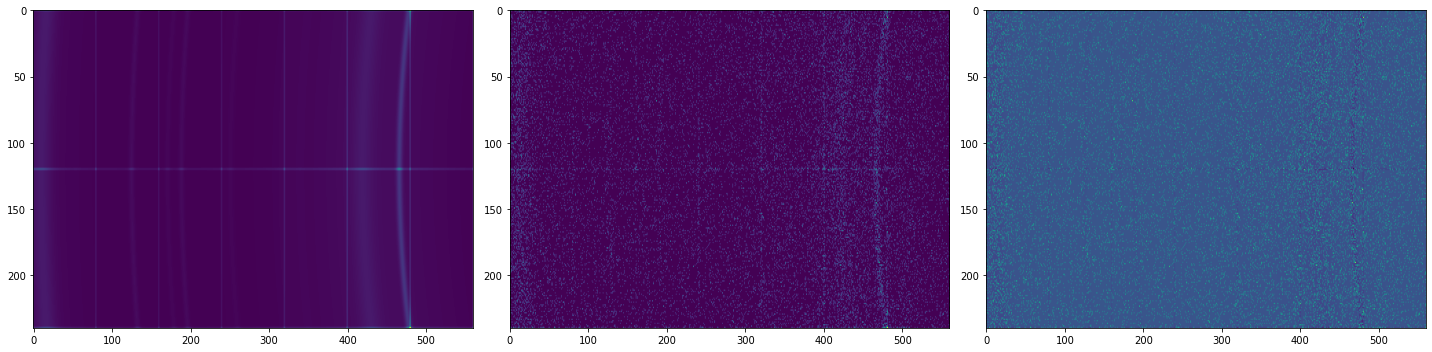

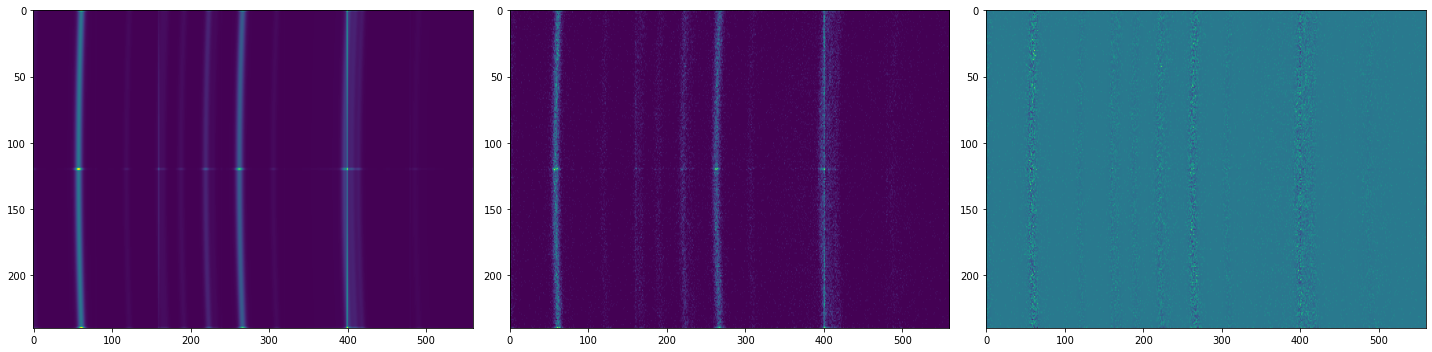

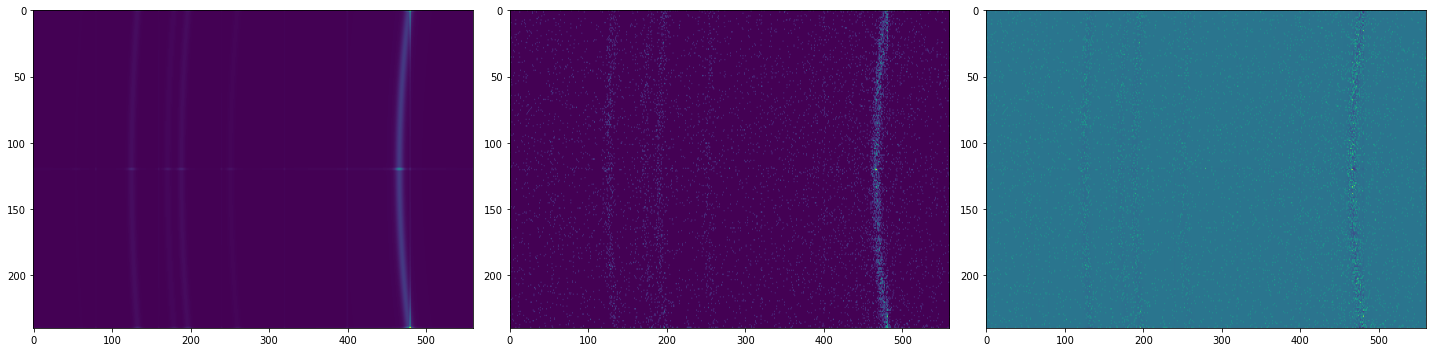

In [ ]:
print(array_combined.shape, array_combined_noise.shape)

print(f'pure - noisy - only noise')
for i, j in zip(array_combined, array_combined_noise):
    i = i.squeeze()
    j = j.squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    
    axs[0].imshow(i, aspect='auto')
    axs[1].imshow(j, aspect='auto')
    axs[2].imshow(j-i, aspect='auto')
    fig.tight_layout()

In [ ]:
INPUT_SHAPE = [*phases_array.shape[3:]]
#INPUT_SHAPE = [*grouped_loaded.shape[3:], 1]
#(28,28,1)

model = Sequential()
# encoder network469/469 [==============================] - 6s 12ms/step - loss: 0.0755 - val_loss: 0.0729
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')


model.summary()

#save in a special format, e.g. with date
name_model_to_disk = os.path.join(wd, 'trained_ae.tfmodel')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 560, 35)      350       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 280, 35)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 280, 25)      7900      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 140, 25)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 140, 25)       5650      
                                                                 
 up_sampling2d (UpSampling2D  (None, 120, 280, 25)     0

In [ ]:
EPOCHS = 30 #20000
INITIAL_EPOCH = 0
#VAL_SPLIT=0.05
BATCH_SIZE = 8
NUMBER_OF_BATCHES = 15
STEPS_PER_EPOCH = NUMBER_OF_BATCHES #int( len(train_IQs)/BATCH_SIZE)
VAL_STEPS = int(NUMBER_OF_BATCHES*0.25) #int( len(val_IQs)/BATCH_SIZE) # +1

train_batches      = class_batchGenerator_general(data_to_combine=phases_array, NUMBER_OF_BATCHES=NUMBER_OF_BATCHES, BATCH_SIZE=BATCH_SIZE, function_generate_patterns=func_combine_n_random_different_ranges)
validation_batches = class_batchGenerator_general(data_to_combine=phases_array, NUMBER_OF_BATCHES=NUMBER_OF_BATCHES, BATCH_SIZE=BATCH_SIZE, function_generate_patterns=func_combine_n_random_different_ranges)


#if __name__ == '__main__':
#	freeze_support()

model.fit(train_batches, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_batches)
model.save(name_model_to_disk)

Epoch 1/30
15/15 [==============================] - 16s 258ms/step - loss: 0.6377 - val_loss: 0.4534
Epoch 2/30
15/15 [==============================] - 3s 234ms/step - loss: 0.1559 - val_loss: 0.0447
Epoch 3/30
15/15 [==============================] - 3s 236ms/step - loss: 0.0568 - val_loss: 0.0568
Epoch 4/30
15/15 [==============================] - 4s 244ms/step - loss: 0.0494 - val_loss: 0.0315
Epoch 5/30
15/15 [==============================] - 4s 241ms/step - loss: 0.0346 - val_loss: 0.0350
Epoch 6/30
15/15 [==============================] - 5s 364ms/step - loss: 0.0296 - val_loss: 0.0313
Epoch 7/30
15/15 [==============================] - 4s 238ms/step - loss: 0.0347 - val_loss: 0.0295
Epoch 8/30
15/15 [==============================] - 4s 241ms/step - loss: 0.0318 - val_loss: 0.0328
Epoch 9/30
15/15 [==============================] - 4s 246ms/step - loss: 0.0293 - val_loss: 0.0353
Epoch 10/30
15/15 [==============================] - 6s 397ms/step - loss: 0.0269 - val_loss: 0.026

In [ ]:
try:
    model = tf.keras.models.load_model(name_model_to_disk)
    model.summary()
except:
    print('no model to load')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 560, 35)      350       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 280, 35)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 280, 25)      7900      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 140, 25)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 140, 25)       5650      
                                                                 
 up_sampling2d (UpSampling2D  (None, 120, 280, 25)     0

In [ ]:
MAX_INT_PER_PIXEL = 300

array_combined, array_combined_noise = func_create_array_of_scaled_patterns(phases_array, func_combine_n_random_different_ranges, 5, MAX_INT_PER_PIXEL)
#array_combined /= MAX_INT_PER_PIXEL
#array_combined_noise /= MAX_INT_PER_PIXEL

predicted = model.predict(
    array_combined_noise, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)

(5, 240, 560, 1) (5, 240, 560, 1)
pure - noisy - difference - reconstructed - diff truth recon


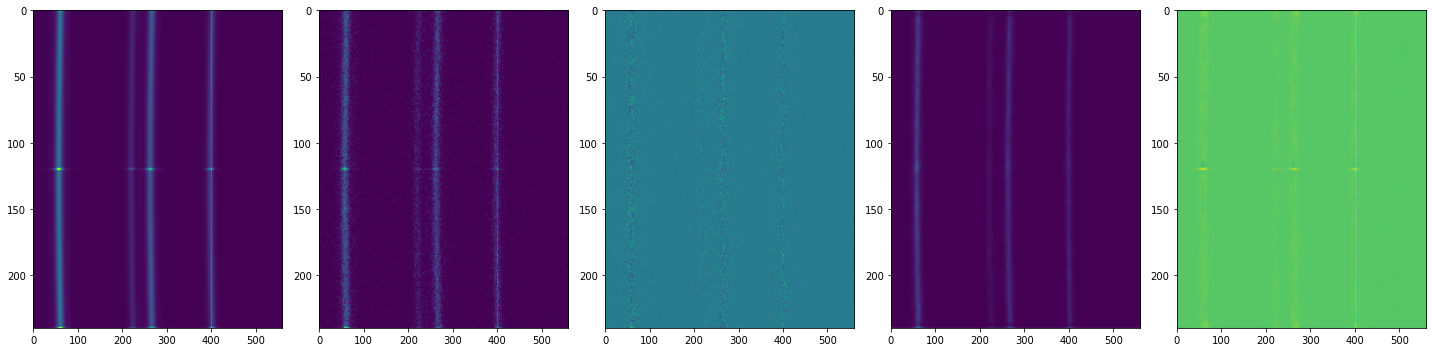

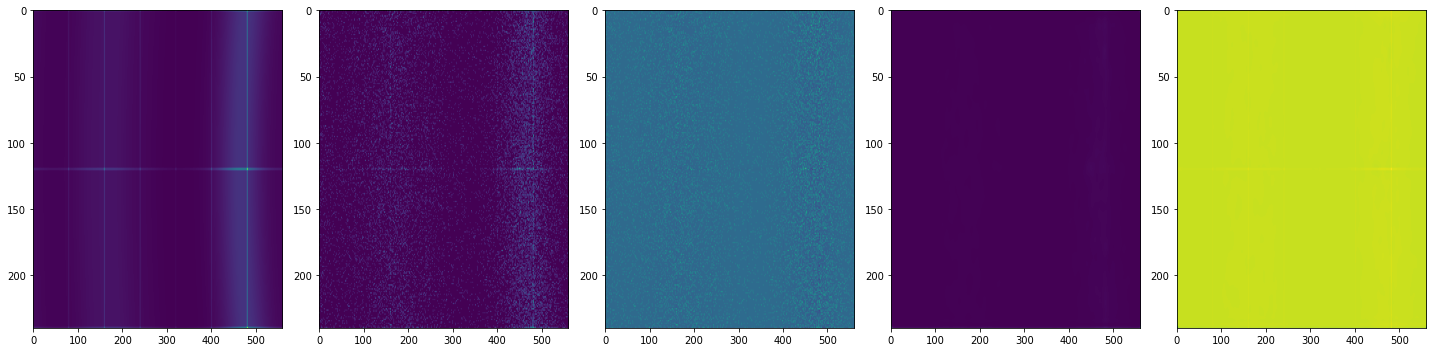

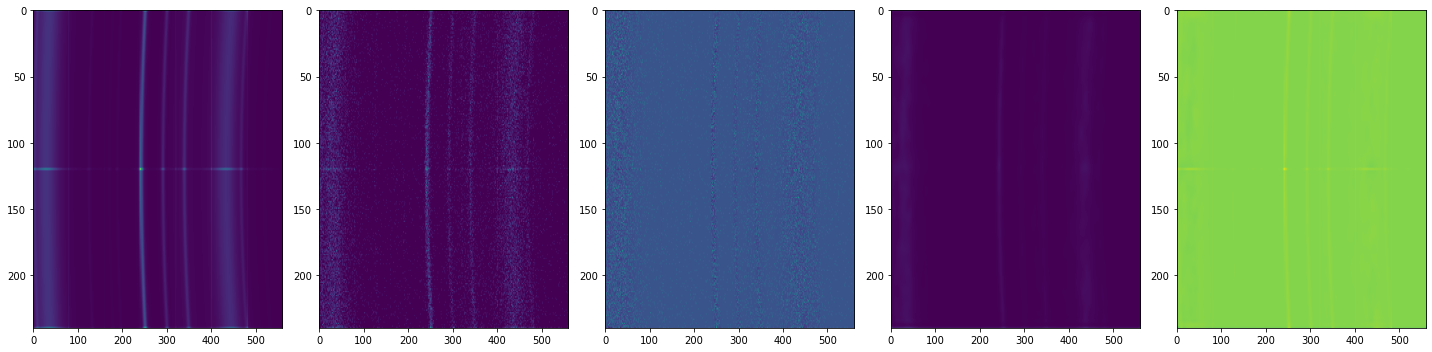

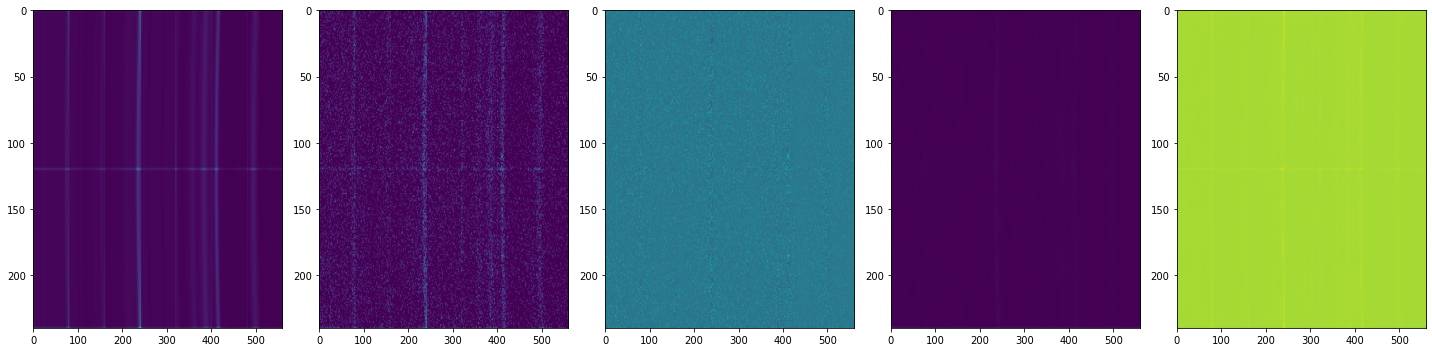

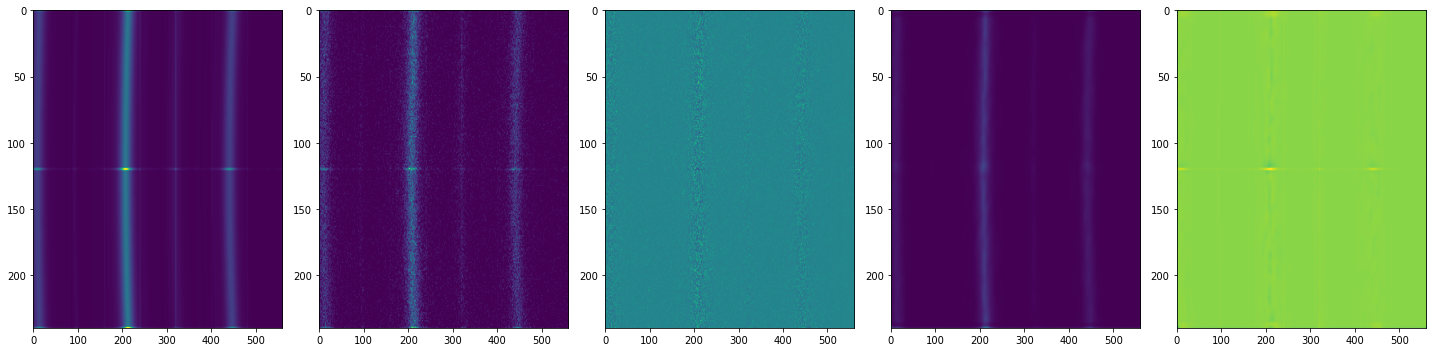

In [ ]:
print(predicted.shape, array_combined_noise.shape)

print(f'pure - noisy - difference - reconstructed - diff truth recon')
for i, j, k in zip(array_combined, array_combined_noise, predicted):
    i = i.squeeze()
    j = j.squeeze()
    k = k.squeeze()

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    
    axs[0].imshow(i, aspect='auto')
    axs[1].imshow(j, aspect='auto')
    axs[2].imshow(j-i, aspect='auto')
    axs[3].imshow(k, aspect='auto')
    axs[4].imshow(i-k, aspect='auto')
    

    fig.tight_layout()

# procedure for 1D
# load merged npys from dir
# group for combination procedure



In [ ]:
files = [f for f in glob.glob(f"{wd}/*.npy")]
files = [file for file in files if '18keV2D' not in file]
files = sorted(files)

groups = func_get_group_common_start(files, takethat=(0,-2))
phases = np.array([ [np.load(npy) for npy in group] for group in groups])
phases = np.array([ [np.expand_dims(np.load(npy), axis=1) for npy in group] for group in groups])
#phases =  [ [np.load(npy) for npy in group] for group in groups ]

In [ ]:
[*phases_array.shape[3:]]

In [ ]:
phases_array = np.array([phases])
shape = phases_array.shape[3:]

try:
    norm = math.prod(shape)
except:
    norm = shape[0]*shape[1]

number_phases_available = len(phases)
len_pattern = len(phases[0][0])
bg = np.zeros(len_pattern)
bg = np.expand_dims(bg, axis=1)
#phases_array = list_numba(phases)
#array_combined = np.empty((5, *bg.shape))
#array_combined = np.expand_dims(array_combined, axis=2)

#max_scale_log = 9

#func_combine_n_random(number_phases_available, func_bg(bg), phases_array, array_combined, max_scale_log=max_scale_log)
#array_combined =
#func_combine_n_random_different_ranges_old(bg, phases_array, array_combined)

array_combined = func_combine_n_random_different_ranges(bg, phases_array, 5)
array_combined = np.array(array_combined)

In [ ]:
array_combined_noise = np.random.poisson(array_combined)

In [ ]:
fig = plt.figure(figsize=(12, 8))
for i, j in zip(array_combined, array_combined_noise):
#for i, j in zip( np.expand_dims(array_combined, axis=2), np.expand_dims(array_combined_noise, axis=2) ):
    plt.plot(j)
    plt.plot(i)
    plt.plot(j-i- 10000)


In [ ]:
n_timesteps,n_features = 10, 5
n_outputs = 30

INPUT_SHAPE = [*phases_array.shape[3:]]


model = Sequential()
model.add(Conv1D(filters=164, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
INPUT_SHAPE = [*phases_array.shape[3:]]
#INPUT_SHAPE = [*grouped_loaded.shape[3:], 1]
#(28,28,1)

model = Sequential()
# encoder network469/469 [==============================] - 6s 12ms/step - loss: 0.0755 - val_loss: 0.0729
model.add(Conv1D(35, 3, activation= 'relu', padding='same', input_shape = INPUT_SHAPE))
model.add(MaxPooling1D(2, padding= 'same'))
model.add(Conv1D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling1D(2, padding= 'same'))
#decoder network
model.add(Conv1D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')


model.summary()

In [ ]:
EPOCHS = 3 #20000
INITIAL_EPOCH = 0

#VAL_SPLIT=0.05
BATCH_SIZE = 16
NUMBER_OF_BATCHES = 30
STEPS_PER_EPOCH = NUMBER_OF_BATCHES #int( len(train_IQs)/BATCH_SIZE)
VAL_STEPS = int(NUMBER_OF_BATCHES*0.25) #int( len(val_IQs)/BATCH_SIZE) # +1

train_batches      = class_batchGenerator_general(data_to_combine=phases_array, number_of_batches=NUMBER_OF_BATCHES, batch_size=BATCH_SIZE, function_generate_patterns=func_combine_n_random_different_ranges)
validation_batches = class_batchGenerator_general(data_to_combine=phases_array, number_of_batches=NUMBER_OF_BATCHES, batch_size=BATCH_SIZE, function_generate_patterns=func_combine_n_random_different_ranges)

#train_batches      = generators.class_batchGenerator(train_IQs, train_COOs, batch_size=BATCH_SIZE, shuffle=True )
#validation_batches = generators.class_batchGenerator(val_IQs,   val_COOs,   batch_size=BATCH_SIZE, shuffle=True)


#if __name__ == '__main__':
#	freeze_support()

model.fit(train_batches, epochs=EPOCHS, batch_size=BATCH_SIZE)


Other ideas to be refined

In [ ]:
encoding_dim = 15 
input_img = Input(shape=(784,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoded representation of code 
decoded = Dense(784, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_img, decoded)

In [ ]:
# This model shows encoded images
encoder = Model(input_img, encoded)

# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))

# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


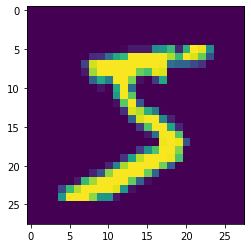

In [ ]:
plt.imshow(x_train[0].reshape(28,28))

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=256,
                validation_data=(x_test, x_test))

Epoch 1/15
235/235 [==============================] - 4s 5ms/step - loss: 0.3114 - val_loss: 0.2247
Epoch 2/15
235/235 [==============================] - 1s 5ms/step - loss: 0.2019 - val_loss: 0.1847
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1765 - val_loss: 0.1668
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1622 - val_loss: 0.1561
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1542 - val_loss: 0.1501
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1497 - val_loss: 0.1469
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1469 - val_loss: 0.1444
Epoch 8/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1447 - val_loss: 0.1424
Epoch 9/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1427 - val_loss: 0.1406
Epoch 10/15
235/235 [==============================] - 1s 5ms/step - loss: 0.1410 - val_loss: 0.1391

In [ ]:
encoded_img = encoder.predict(x_test)

In [ ]:
decoded_img = decoder.predict(encoded_img)

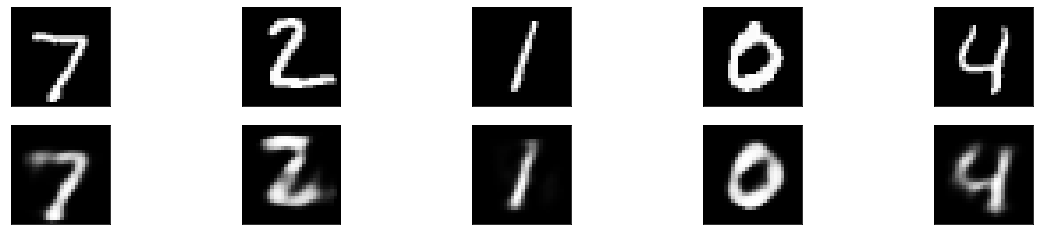

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))


In [ ]:
#decoder network
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 15)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 15)          2040      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 30)        4

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
model.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                validation_data=(x_test, x_test))

Epoch 1/15
469/469 [==============================] - 33s 13ms/step - loss: 0.1259 - val_loss: 0.0802
Epoch 2/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0777 - val_loss: 0.0752
Epoch 3/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0744 - val_loss: 0.0728
Epoch 4/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0728 - val_loss: 0.0715
Epoch 5/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0717 - val_loss: 0.0708
Epoch 6/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0709 - val_loss: 0.0700
Epoch 7/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0702 - val_loss: 0.0693
Epoch 8/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0696 - val_loss: 0.0690
Epoch 9/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0692 - val_loss: 0.0685
Epoch 10/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0688 - val_l

In [ ]:
pred = model.predict(x_test)

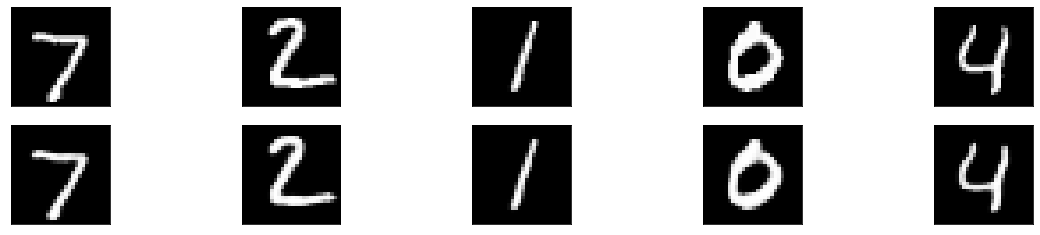

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### introduce noise in the images

In [ ]:
"""noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)"""

'noise_factor = 0.7\nx_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) \nx_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) \n\nx_train_noisy = np.clip(x_train_noisy, 0., 1.)\nx_test_noisy = np.clip(x_test_noisy, 0., 1.)'

In [ ]:
x_train_noisy = x_train #+ np.random.poisson(x_train)
x_test_noisy = x_test #+  np.random.poisson(x_test)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

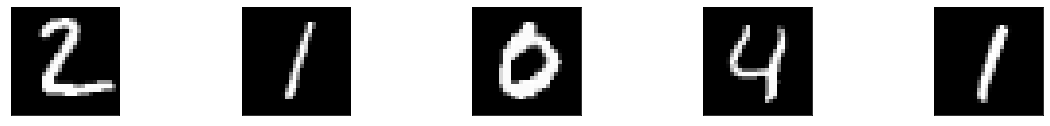

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
scale = 10.
x_train /= scale
x_test  /= scale
x_train_noisy = np.random.poisson(x_train)
x_test_noisy  = np.random.poisson(x_test)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

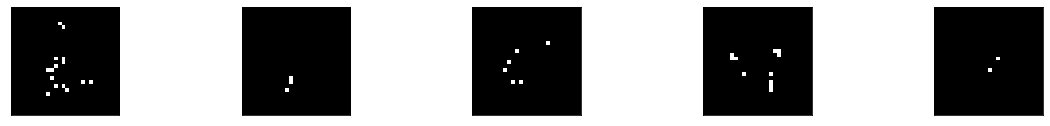

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
model.fit(x_train_noisy, x_train/scale,
                epochs=15,
                batch_size=128,
                validation_data=(x_test_noisy, x_test/scale))

Epoch 1/15
469/469 [==============================] - 8s 16ms/step - loss: 0.0289 - val_loss: 0.0089
Epoch 2/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 3/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 4/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 5/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 7/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 8/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 9/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 10/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0085 - val_lo

In [ ]:
pred = model.predict(x_test_noisy)

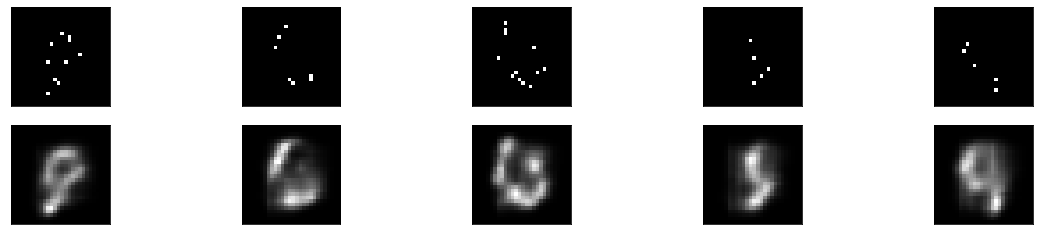

In [ ]:
shift = 20
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i+shift].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i+shift].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1D conv

In [ ]:
n_timesteps,n_features = 10, 5
n_outputs = 30

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
  import tensorflow as tf

  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  print(x_train.shape)
  print(x_test.shape)
  


  

  def func_provide_data(x_train, x_test):
    """
    """
    scale = 1.0
    x_train_noisy = x_train/scale + np.random.poisson(x_train/scale)
    x_test_noisy = x_test/scale +  np.random.poisson(x_test/scale)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    obj = x_train
    nb_of_examples, nb_of_features = len(obj), len(obj[0])
    x_train = x_train.reshape((nb_of_examples, nb_of_features, 1))
    x_train_noisy = x_train_noisy.reshape((nb_of_examples, nb_of_features, -1))

    obj = x_test
    nb_of_examples, nb_of_features = len(obj), len(obj[0])
    x_test = x_test.reshape((nb_of_examples, nb_of_features, 1))
    x_test_noisy = x_test_noisy.reshape((nb_of_examples, nb_of_features, -1))
    
    print(x_train.shape)
    print(x_test.shape)
    input_shape = (100, 10, 128)
    a = tf.random.normal(input_shape)
    input_shape = (100, 128)
    b = tf.random.normal(input_shape)

    input_shape = (40, 10, 128)
    c = tf.random.normal(input_shape)
    input_shape = (40, 128)
    d = tf.random.normal(input_shape)

    #a = np.expand_dims(a, axis=1)
    #b = np.expand_dims(b, axis=1)
    #c = np.expand_dims(c, axis=1)
    #d = np.expand_dims(d, axis=1)

    #return x_train_noisy, x_train, x_test_noisy, x_test
    return a, b, c, d



  

In [ ]:
#help(Conv1D)
#x_train.shape[2]

In [ ]:
obj = x_train
nb_of_examples, nb_of_features = len(obj), len(obj[0])
x_train = x_train.reshape((nb_of_examples, nb_of_features, 1))
#x_train_noisy = x_train_noisy.reshape((nb_of_examples, nb_of_features, -1))

print(x_train.shape)
print(x_test.shape)

len(x_train[0][0])

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
  """
  """
  verbose, epochs, batch_size = 0, 15, 32
  print(trainX.shape)
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_kernel.png')


# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = func_provide_data(x_train, x_test)   #load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

# run the experiment
n_params = [2, 3, 5, 7, 11]
n_params = [2]
run_experiment(n_params)

In [ ]:
# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical


# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elementIf you need help setting up your Python development environment, a tutorial is provided in the appendix of most books showing you exactly how to do this.s
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy



In [ ]:
filename = 'myimage.png'
imagea = (scipy.misc.imread(filename)).astype(float)

poissonNoise = numpy.random.poisson(imagea).astype(float)

noisyImage = imagea + poissonNoise


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=12c5ff881d8ded6efbcd647771c6f2c475948c4c07986cffbf88122f4d43cc78
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.4 GB  | Proc size: 895.0 MB
GPU RAM Free: 11320MB | Used: 121MB | Util   1% | Total 11441MB
